In [1]:
using Revise
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack
using Plots
using LinearAlgebra
using StatsBase
using MultivariateStats
using Kronecker: ⊗, kronecker
using SparseArrays: sparse

┌ Info: Precompiling HypergraphDetectability [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphDetectability does not have StatsBase in its dependencies:
│ - If you have HypergraphDetectability checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphDetectability
└ Loading StatsBase into HypergraphDetectability from project dependency, future warnings for HypergraphDetectability are suppressed.


In [2]:
function transform_eigenvector(v, H)
    n = length(H.N)
    k̄ = length(keys(H.E))
    α = v[((length(v)÷2)+1):end]
    ℓ = length(α) ÷ (n*k̄)
    U = zeros(n, ℓ)
    for i ∈ 1:n, k ∈ 1:k̄, s ∈ 1:ℓ
        U[i, s] += α[i + (k-1)*n + (s-1)*(n*k̄)]
    end
    return U
end

transform_eigenvector (generic function with 1 method)

In [3]:
H, z = HypergraphDetectability.read_hypergraph_data("contact-primary-school-classes");

In [4]:
@time J = reducedBPJacobian(H, z);

 23.385384 seconds (14.52 M allocations: 1.774 GiB, 2.20% gc time)


In [5]:
@time E = Arpack.eigs(J; nev = 200);

 35.003612 seconds (7.81 M allocations: 712.930 MiB, 0.75% gc time)


In [6]:
sum(imag.(E[1]) .≈ 0)

190

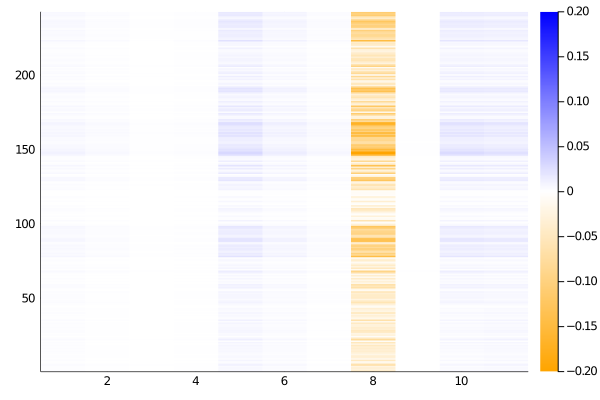

In [7]:
n = length(H.N)
k̄ = length(keys(H.E))
ℓ = length(unique(z))

U = zeros(n, ℓ)

j = 6

for i ∈ j:j
    v = E[2][:, i]
    U += transform_eigenvector(v, H);
end 

heatmap(U[sortperm(z),:], 
        c = cgrad([:orange, :white, :blue], 
        [-1.0, 0.0, 1.0]), 
    clims=(-.2,.2))

In [8]:
# consensus clustering?!?!
C = zeros(n, n)

for h ∈ 1:100
    v = E[2][:, h]
    U = transform_eigenvector(v, H);
    for s ∈ 1:ℓ, i ∈ 1:n, j ∈ 1:n
        C[i,j] += (sign(U[i, s]) == sign(U[j, s]))
#         C[i,j] += real(E[1][h])*U[i,s]*U[j,s]
    end
end

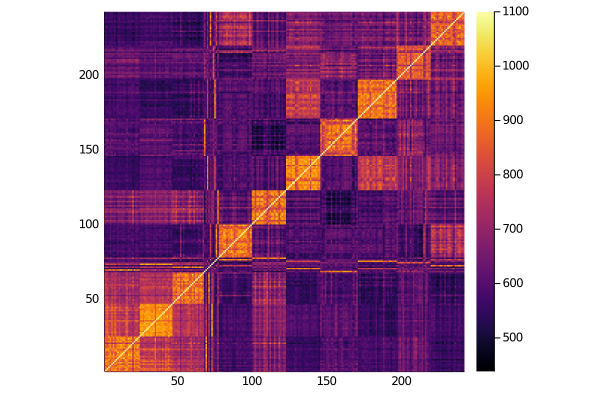

In [9]:
heatmap(C[sortperm(z), sortperm(z)], 
        aspect_ratio=:equal, 
        xlim = (1, n), 
        ylim = (1, n))

In [10]:
nev = 100
ngroups = 11
ẑ = rand(1:ngroups, n);
# ẑ = z;

In [11]:
for i ∈ 1:5
    ẑ = HypergraphDetectability.NBSC_round(H, ẑ; nev = nev, ngroups = ngroups)
    println(randindex(z, ẑ)[1])
end

0.8700027980126539
0.86971428176979
0.6365231467648865
0.7005817366696055
0.8793587651015776
